# 1. RNNs para series de tiempo

<hr style="height:2px;border:none"/>
<h1 align='center'> <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />

INF-395 / 477 / 577 Tarea 2 Redes Neuronales Artificiales - 2020-2 </h1>

<H3 align='center'> Integrantes: Paula Nieto - Gabriela Sepúlveda </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones en tensorflow, keras, pandas y numpy
* Recurrent Neural Networks
* LSTM, GRU
* Autoencoders
* GAN

**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos). Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno para toda la tarea, con tal de que todos los entregables estén bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_ ( en caso de ser repositorio privado, invitar como colaborador al usuario de github "Aerlio") al correo electrónico del ayudante (*<tomas.ochoa.14@sansano.usm.cl>*), en copia al profesor (*<cvalle@inf.utfsm.cl>*). Especificar el siguiente asunto: [INF395/477/577-2020 Tarea 2]
* Fecha de entrega y presentaciones: 8 de Enero. Hora límite de entrega: 23:00. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail. 

<hr style="height:2px;border:none"/>

La tarea se divide en tres partes:

[1.](#primero) RNNs para series de tiempo  <br>
[2.](#segundo) RNNs para texto <br>
[3.](#tercero) Autoencoders para imágenes <br>
[3.](#cuarto) GANs para imágenes <br>

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo solo son guías y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con comentarios y con celdas _Markdown_ con los comentarios de la pregunta y con cualquier analisis, fórmula o explicación que les parezca relevante para justificar sus procedimientos. 
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en si, en cambio la argumentación detrás de la elección será lo más ponderado.

**Es ÁLTAMENTE recomendado realizar esta tarea en _Colab_ de Google (https://colab.research.google.com/notebooks/intro.ipynb#recent=true), con el fin de no depender del rendimiento de su computador personal al momento de entrenar redes neuronales y poder compartir de forma fácil sus avances con su compañer@ de trabajo.** Si bien conlleva sus pros y contras utilizar _Colab_ , existirá una curva de aprendizaje personal que lo ayudará a sacar el mayor provecho a esta herramienta, por ejemplo aprendiendo a guardar los avances realizados, evitando tener que ejecutar todo el código cada vez que se abra _Colab_ . *Tip: Una vez abierto un notebook en _Colab_ ir a **entorno de ejecución**->**Cambiar tipo de entorno de ejecución**, y seleccionár TPU como acelerador por hardware para redes recurrentes y GPU para redes convolucionales.*.

Las redes neuronales recurrentes (RNNs) son una red neuronal profunda que tiene, como su nombre indica, entradas recurrentes en la capa oculta, es decir, la salida de una capa oculta se retroalimenta a sí misma. La memoria neuronal es la capacidad impartida a un modelo para retener la entrada de los pasos de tiempo anteriores cuando la entrada es secuencial. En términos simples, cuando nuestro problema está asociado con una secuencia de datos como una oración o una serie temporal o la letra de una canción, el modelo tiene que recordar los estados previos de la entrada para funcionar.

<h1 align='center'> <img src="https://www.hobodataloggers.com.au/images/thumbs/0007371_hobo-weather-station-kits_510.jpeg" width="50%" height="100%" /> </h1>

En esta pregunta trabajaremos con datos obtenidos presumiblemente de una estación meteorológica, los cuales se obtienen desde el sitio https://www.kaggle.com/dronio/SolarEnergy, este dataset contiene mediciones de los últimos 4 meses. Nuestro objetivo será predecir el nivel de radiación solar para la próximas 24 horas.


## 1.a Carga de datos y preprocesamiento.

##### I) Iniciaremos cargando los datos. Para esto necesitará crear una cuenta en kaggle, dirigirse a su perfil, ir a Account, y en la sección API apretar _Create new API token_ , se descargará un archivo kaggle.json, ábralo como archivo de texto y obtenga su username y key. Luego ejecute el siguiente código (desconozco por qué pero a veces hay que ejecutar el código 2 veces para que funcione). Solución obtenida desde el hilo: https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27

In [ ]:
username="gabrielasepulveda"
key="c4e7170af8d4e1a4413214439170379f"

!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d dronio/SolarEnergy
if not os.path.exists("/content/solar_prediction"):
    os.makedirs("/content/solar_prediction")
os.chdir('/content/solar_prediction')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

  0% 0.00/511k [00:00<?, ?B/s]
100% 511k/511k [00:00<00:00, 76.1MB/s]
SolarEnergy.zip  SolarPrediction.csv


Procederemos a ordenar la serie temporalmente a continuación.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu') # to convert unixtime
dataset = pd.read_csv('SolarPrediction.csv') # read data
dataset = dataset.sort_values(['UNIXTime'], ascending = [True]) #sort data
dataset.index =  pd.to_datetime(dataset['UNIXTime'], unit='s') # make unix pandas dataframe index
dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(hawaii) # convert unixtime to timestamp
dataset.drop(['Data','Time','TimeSunRise','TimeSunSet',"UNIXTime"], inplace=True, axis=1) # drop extra-time variables
dataset.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
UNIXTime,,,,,,
2016-09-01 00:00:08-10:00,2.58,51,30.43,103,77.27,11.25
2016-09-01 00:05:10-10:00,2.83,51,30.43,103,153.44,9.00
2016-09-01 00:20:06-10:00,2.16,51,30.43,103,142.04,7.87
2016-09-01 00:25:05-10:00,2.21,51,30.43,103,144.12,18.00
2016-09-01 00:30:09-10:00,2.25,51,30.43,103,67.42,11.25


**Comentario:** Se puede observar inmediatamente que existen datos faltantes, los cuales no son declarados. Dado que de los 6 datos impresos se puede inferir que el timestep es de 5 minutos, y faltarían los datos del instante 2016-09-01 ~00:10:00 y 2016-09-01 ~00:15:00

A continuación se proveen comandos con los cuales se puede observar cómo a partir del timestamp generado se puede categorizar con comandos simples el dataset según minuto del día, hora del día, mes del año, y día del año. Los cuales se ocuparán durante la tarea. 

In [ ]:
dataset.index.minute,dataset.index.hour,dataset.index.month,dataset.index.dayofyear

(Int64Index([ 0,  5, 20, 25, 30, 45, 50, 55,  0,  5,
             ...
             10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
             ...
             23, 23, 23, 23, 23, 23, 23, 23, 23, 23],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
             ...
             12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([245, 245, 245, 245, 245, 245, 245, 245, 245, 245,
             ...
             366, 366, 366, 366, 366, 366, 366, 366, 366, 366],
            dtype='int64', name='UNIXTime', length=32686))

##### II) Para poder idententificar los Missing Values, y poder contar de manera segura con días de 24 horas, ejecute el siguiente código. **Explique** la funcionalidad del código escrito, escribiendo en forma de comentario (#) sobre las líneas de este código.

In [ ]:
import time
# Se define el tiempo inicial
t1=time.time() 
# Se crea una matriz m x n, m = samples, n = columnas del dataset + 1 (tiempo).
new_data=np.nan*np.zeros((24*12*(len(np.unique(dataset.index.dayofyear))),1+len(dataset.columns)), dtype=object)
# Arreglo con los días sin repetir
days=np.unique(np.asarray([str(dataset.index[i]).split(" ")[0] for i in range(dataset.shape[0])]))

# Transforma los minutos integer a string
def min_to_str(min):
  if min==0: min="00"
  elif min==5: min="0"+str(min)
  else: min=str(min)
  return(min)

# Transforma la hora con para que estén las horas 0 hrs-23 hrs con 5 mins de diferencia, y se guarda en new_data
for i in range(new_data.shape[0]):
  hr=i//12-24*((i//12)//24)
  if hr==0: hr="00"
  elif 0<hr<10: hr="0"+str(hr)
  else: hr=str(hr)
  min=5*i-60*((5*i)//60)
  day=(i//12)//24
  new_data[i,0]=days[day]+" "+str(hr)+":"+min_to_str(min)+":00"

verbose,freq=True,12*24*5+12+1 # to see output
w_in=0

# Se parsean los datos en new_data
for i in range(dataset.shape[0]):
  ind=dataset.index[i]
  min=ind.minute
  # Si existen minutos antes, se guarda
  if i>0: past_min=dataset.index[i-1].minute
  # Si existen minutos despues, se guarda
  if i<dataset.shape[0]-1: next_min=dataset.index[i+1].minute
  # Si el minuto no es múltiplo de 5 y hay resto, lo modifica de tal manera que no sea menor que el tiempo anterior o mayor que el posterior
  if min%5!=0:
    if (min+1)%5==0: min=min+1
    elif (min-1)%5==0: min=min-1
    elif past_min%5==0:
      if past_min!=55: min=past_min+5
      else: min=0
    elif next_min%5==0:
      if next_min!=0: min=past_min-5
      else: min=55
    elif (past_min-1)%5==0:
      if (past_min-1)!=55: min=past_min-1+5
      else: min=0
    else: print(past_min,min,next_min,"---keep expanding")
  # Se escribe el tiempo como un string en ind
  ind=str(ind)[:-11]+min_to_str(min)+str(ind)[-9:]
  found=0
  # Guarda la información del dataset en new_data, para un tiempo ind
  for w in range(w_in,w_in+new_data.shape[0]):
    if new_data[w,0][:-2] in ind:
      w_in=w
      found=1
      new_data[w,1:]=dataset.values[i,:]
      if verbose and i%freq==0: print(str(dataset.index[i]),"---->",new_data[w,0])
      break
  if found==0:
    print("Error at ",ind)
    break

# Se define un dataframe con los datos procesados
df=pd.DataFrame(new_data[:,1:].astype("float32"),index=new_data[:,0],columns=dataset.columns)
# Se define el tiempo final
t2=time.time()
print("Time of computation (seconds): ", t2-t1)
print("N° Missing time steps data: ", np.isnan(new_data[:,1].astype("float")).sum())

2016-09-01 00:00:08-10:00 ----> 2016-09-01 00:00:00
2016-09-06 07:05:20-10:00 ----> 2016-09-06 07:05:00
2016-09-13 02:25:08-10:00 ----> 2016-09-13 02:25:00
2016-09-19 03:20:05-10:00 ----> 2016-09-19 03:20:00
2016-09-24 06:30:19-10:00 ----> 2016-09-24 06:30:00
2016-09-29 11:15:22-10:00 ----> 2016-09-29 11:15:00
2016-10-05 14:35:20-10:00 ----> 2016-10-05 14:35:00
2016-10-10 18:25:23-10:00 ----> 2016-10-10 18:25:00
2016-10-15 21:50:21-10:00 ----> 2016-10-15 21:50:00
2016-10-20 23:50:20-10:00 ----> 2016-10-20 23:50:00
2016-10-26 01:25:17-10:00 ----> 2016-10-26 01:25:00
2016-10-31 02:45:17-10:00 ----> 2016-10-31 02:45:00
2016-11-05 04:15:18-10:00 ----> 2016-11-05 04:15:00
2016-11-10 05:20:02-10:00 ----> 2016-11-10 05:20:00
2016-11-15 06:25:02-10:00 ----> 2016-11-15 06:25:00
2016-11-20 07:40:20-10:00 ----> 2016-11-20 07:40:00
2016-11-25 09:00:04-10:00 ----> 2016-11-25 09:00:00
2016-12-01 14:55:04-10:00 ----> 2016-12-01 14:55:00
2016-12-09 06:25:52-10:00 ----> 2016-12-09 06:25:00
2016-12-14 0

##### III) **Reemplace** TODOS los missing values (NaN) de cada columna del nuevo dataset (df) de la forma que estime conveniente. Para esto debe usar los valores respectivos de cada columna, ya sea en el pasado o futuro. <br><br> _Como ejemplo_: Si es que existen datos perdidos a las 23:15 hrs, puede reemplazar el valor NaN con el promedio entre las 23:10 y 23:20, teniendo cuidado que el valor en la columna a reemplazar p.ej Pressure sea efectivamente el promedio entre la variable Pressure a las 23:10 y 23:20 . Note que el promedio entre un valor númerico y NaN es igual a NaN, por lo que tendrá que encontrar cómo hacer frente a esta situación.  <br><br> **Comente y fundamente su elección.**

In [ ]:
def findIndex(index, increment, nan_array):
  while(np.any(nan_array[:] == index)):
    index += increment
  return index

time=pd.to_datetime(df.index)
var_names=df.columns.tolist()
data=df.copy().values
nan_row_loc=np.where((np.isnan((data[:,0]))==True))

while(len(nan_row_loc[0]) > 0):
  index = nan_row_loc[0][0]
  x1 = index - 1
  x2 = findIndex(index, +1, nan_row_loc[0])
  # Si el primer elemento es nan, entonces será igual al primer elemento que no sea nan a la derecha
  if(x1 < 0):
    x1 = findIndex(index, +1, nan_row_loc[0])
  # Si el último elemento es nan, entonces será igual al primer elemento que no sea nan a la izquierda
  if(x2 > np.shape(data)[0]):
    x2 = findIndex(index, -1, nan_row_loc[0])
  data[index] = (data[x1] + data[x2]) / 2
  nan_row_loc=np.where((np.isnan((data[:,0]))==True))

# Validamos si tenemos data NaN
np.isnan((data)).sum()

0

**Comentarios**

Debido a que los datos están ordenados secuencialmente, se capturó el índice de la primera fila que es nan. Luego, se reviso que los indices contiguos tuvieran datos, en caso de no tener se movía el indice hasta encontrar un dato. Finalmente se calcula el promedio de los datos en 2 los índices definidos y se guardan, se realiza esto hasta que no hayan datos que sean nan.

Se decidió hacer de esta manera porque si se tomaban los datos a cada lado y uno era nan, el dato seguiría siendo nan quedando en un loop infinito. Además, se considera que si los datos nan estan en la primera o última posición del array, se tomará el dato más cercano y no el promedio de dos datos, ya que en uno de los lados no hay más datos.

**Para disminuir los tiempos de entrenamiento reduciremos la resolución temporal de 5-min a 1-hr. Para esto calcularemos el promedio de cada hora.**

In [ ]:
data_hr=np.nan*np.zeros((int(data.shape[0]/12),data.shape[1]))
time_hr=np.nan*np.zeros((int(data.shape[0]/12)), dtype=object)
for i in range(data_hr.shape[0]):
  data_hr[i,:]=np.mean(data[12*i:12*(i+1),:],axis=0)
  time_hr[i]=time[12*i]
time_hr=pd.to_datetime(time_hr)

In [ ]:
time_hr

DatetimeIndex(['2016-09-01 00:00:00', '2016-09-01 01:00:00',
               '2016-09-01 02:00:00', '2016-09-01 03:00:00',
               '2016-09-01 04:00:00', '2016-09-01 05:00:00',
               '2016-09-01 06:00:00', '2016-09-01 07:00:00',
               '2016-09-01 08:00:00', '2016-09-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', length=2832, freq=None)

##### IV) **Separe** el dataset en conjuntos de entrenamiento, validación y test, para esto considere un 70% de los datos para entrenamiento, un 15% para validación y un 15% para test. Como se está trabajando con series de tiempo, proceda a crear los conjuntos de manera sucesiva. Guarde las fechas asociadas a cada dato puesto se utilizarán más adelante. 

In [ ]:
data_tr, time_tr = data_hr[:int(data_hr.shape[0]*0.7)],time_hr[:int(data_hr.shape[0]*0.7)]
data_val, time_val = data_hr[int(data_hr.shape[0]*0.7):int(data_hr.shape[0]*0.85)],time_hr[int(data_hr.shape[0]*0.7):int(data_hr.shape[0]*0.85)]
data_tst, time_tst = data_hr[int(data_hr.shape[0]*0.85):],time_hr[int(data_hr.shape[0]*0.85):]
print(data_tr.shape[0], data_val.shape[0], data_tst.shape[0])

1982 425 425


**Verificación de los tamaños de conjuntos**

In [ ]:
total = data_hr.shape[0]
data_tr_size, data_val_size, data_test_size = (100 / total)*data_tr.shape[0], (100 / total)*data_val.shape[0], (100 / total)*data_tst.shape[0]
print('Para x (size=%d):'%total)
print('\t- Train Set > %f%%\n\t- Validation Set > %f%%\n\t- Test Set > %f%%\n'%(data_tr_size,data_val_size,data_test_size))

Para x (size=2832):
	- Train Set > 69.985876%
	- Validation Set > 15.007062%
	- Test Set > 15.007062%



##### V) **Comente y visualice** los valores promedios y desviación estándar de cada atributo del dataset de entrenamiento según la hora del día y mes del año. Apóyese en el siguiente código si lo desea.

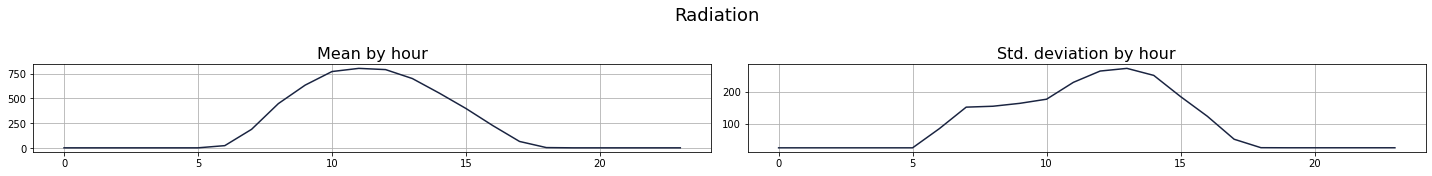

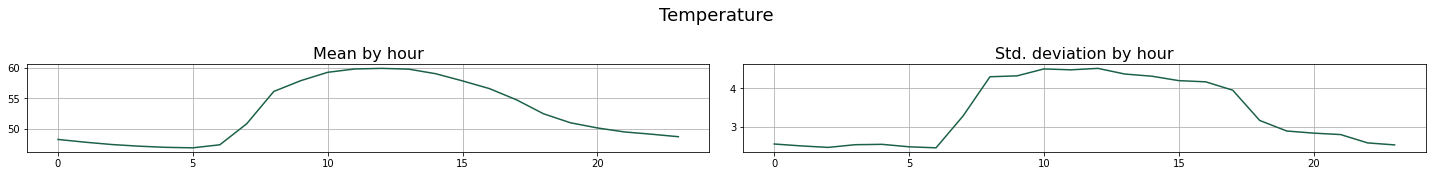

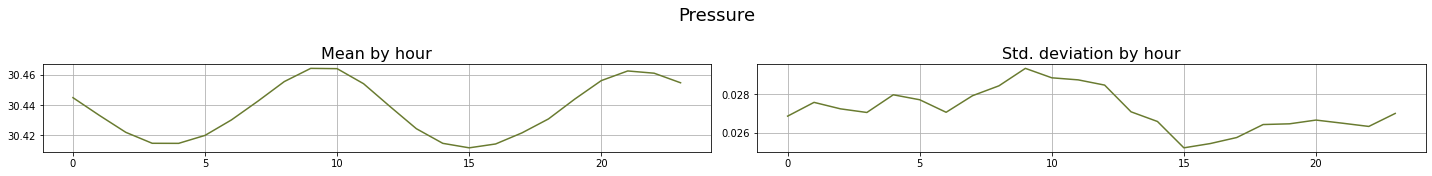

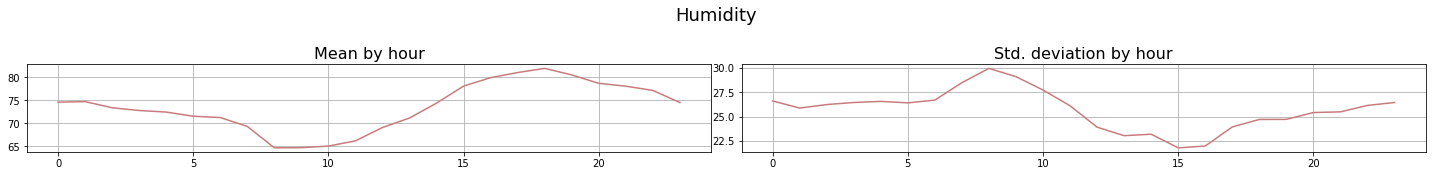

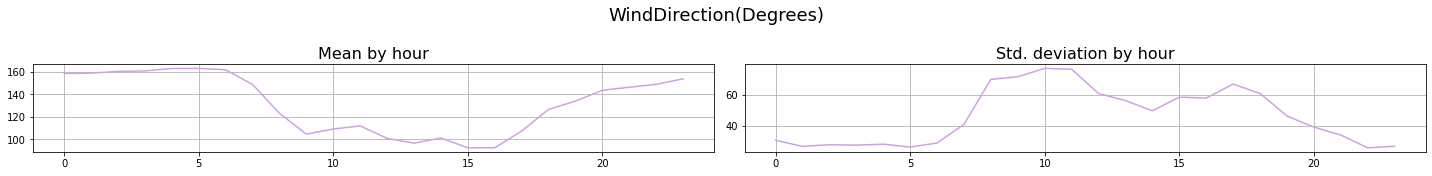

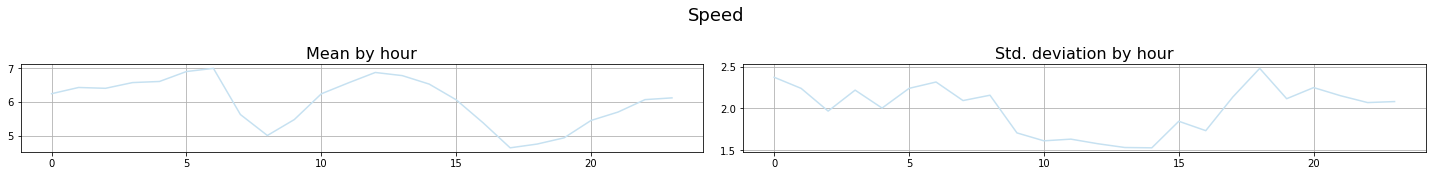

In [ ]:
import matplotlib.pyplot as plt
cols=sns.color_palette("cubehelix", len(var_names))
for J in range(len(var_names)):
  var_name=var_names[J]
  mean_per_hr=np.nan*np.zeros((24))
  std_per_hr=np.nan*np.zeros((24))
  for hr in range(24):
    mean_per_hr[hr]=np.mean(data_tr[time_tr.hour==hr][:,J])
    std_per_hr[hr]=np.std(data_tr[time_tr.hour==hr][:,J])
  plt.rcParams["figure.figsize"]=[20,2]
  plt.suptitle(var_name,size=18,y=1.2)
  plt.subplot(1,2,1),plt.title("Mean by hour",size=16)
  plt.plot(mean_per_hr,color=cols[J]),plt.grid()
  plt.subplot(1,2,2),plt.title("Std. deviation by hour",size=16)
  plt.plot(std_per_hr,color=cols[J]),plt.grid()
  plt.tight_layout()
  plt.show()

**Comentarios**

* Radiación: Se puede ver que este atributo está normalizado, donde el valor central es el 11, que indica las 12am. Si bien la desviación es mas irregular, también se observa una tendencia a la normalización.
* Temperatura: La temperatura es un atributo relativamente normalizado, ya que sigue la curva de campana pero tiene mayor dispersión que la anterior debido a su desviación estándar.
* Presión: Se puede observar como este atributo tiene un comportamiento más bien cíclico.
* Humedad: En cuanto a la humedad vemos una distribución bimodal.
* Dirección del viento: En cuanto a este atributo se observa una distribución en forma de U.
* Speed: Se observa una distribución multimodal.




##### VI) **Estandarice** los conjuntos de entrenamiento, validación y test. Tienendo en mente que buscaremos predecir la radiación para las 24 horas futuras definiremos las variables de entrada y salida, realizando una transformación conveniente utilizando la función split_sequence entregada.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_tr)
xy_tr_sc = scaler.transform(data_tr)
xy_val_sc = scaler.transform(data_val)
xy_tst_sc = scaler.transform(data_tst)

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out,time_seq):
    X, y , seq_t= list(), list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix,0]
        seq_t.append(time_seq[end_ix])
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y) , np.asarray(seq_t)

In [ ]:
len_inp=24
len_out=24
x_tr,y_tr,t_tr=split_sequence(xy_tr_sc,len_inp,len_out,time_tr)
x_val,y_val,t_val=split_sequence(xy_val_sc,len_inp,len_out,time_tr)
x_tst,y_tst,t_tst=split_sequence(xy_tst_sc,len_inp,len_out,time_tr)

**Explique** a qué corresponde cada dimensión de las variables de entrada y salida.

In [ ]:
x_tr.shape,x_val.shape,x_tst.shape,y_tr.shape,y_val.shape,y_tst.shape

((1935, 24, 6), (378, 24, 6), (378, 24, 6), (1935, 24), (378, 24), (378, 24))

**Dimensiones**

Datos de entrada: 

* x_tr: Los datos de entrenamiento cuentan con 1935 días, 24 mediciones por cada hora de un día, 6 valores por cada atributo.
* x_val: Los datos de validación cuentan con 378 días, 24 mediciones por cada hora de un día, 6 valores por cada atributo.
* x_tst: Los datos de test cuentan con 378 días, 24 mediciones por cada hora de un día, 6 valores por cada atributo.

Datos de salida:

* y_tr: Los datos de entrenamiento cuentan con 1935 días, 24 mediciones por cada hora de un día, 6 valores por cada atributo.
* y_val: Los datos de validación cuentan con 378 días, 24 mediciones por cada hora de un día, 6 valores por cada atributo.
* y_tst: Los datos de test cuentan con 378 días, 24 mediciones por cada hora de un día, 6 valores por cada atributo.

Cabe destacar que se redujeron algunos datos debido a que no se encontraban los datos exactos para separarlos en datos de entrada y salida, para esto se requerían 48 datos (24 datos pasados y 24 datos futuros) pero solo habían 47, por lo que fueron recortados.

## 1.b) Primera  red recurrente.
Ahora entrenaremos una primera red recurrente LSTM. **Explique** la particularidad de estas redes y **por qué** podría comportarse bien para este tipo de problemas. <br> <br> Entrenaremos dos redes recurrentes similares, la primera tan solo utilizará la variable Radiation como entrada para predecir Radiation, caso que llamaremos **univariante**, mientras la segunda utilizará las variables [Radiation, Temperature, Pressure, Humidity, WindDirection(Degrees), Speed] como entrada para predecir Radiation, caso que llamaremos **multivariante**. <br> <br> **Recupere** las funciones utilizadas en la tarea anterior para graficar los errores de entrenamiento, validación y test, y así comparar el rendimiento de ambas redes RNN gráficamente. **Comente**

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer

input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens=layers.Dense(len_out, activation='sigmoid')(rnn)
model_1=models.Model(inputs=input_lstm, outputs=dens)
model_1.compile(loss='mse', optimizer='adam')

model_1.summary()
history_1 = model_1.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=10, batch_size=16,verbose=False)

input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens=layers.Dense(len_out, activation='sigmoid')(rnn)
model_2=models.Model(inputs=input_lstm, outputs=dens)
model_2.compile(loss='mse', optimizer='adam')

model_2.summary()
history_2 = model_2.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=False)

y_pred_1=model_1(x_tst[:,:,0:1])
tst_loss_1=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_1)).numpy()
y_pred_2=model_2(x_tst)
tst_loss_2=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_2)).numpy()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 56)                12992     
_________________________________________________________________
dense (Dense)                (None, 24)                1368      
Total params: 14,360
Trainable params: 14,360
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 56)                14112     
________________________________________

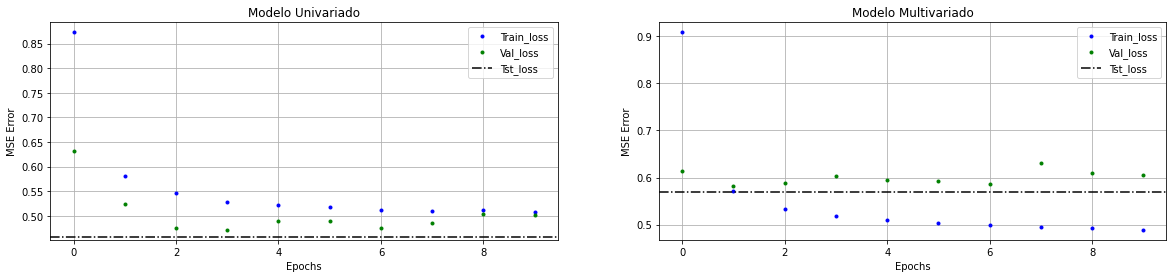

In [ ]:
plt.rcParams["figure.figsize"]=[20,4]

# First model
plt.subplot(1,2,1)
plt.title("Modelo Univariado")
plt.plot(history_1.history["loss"],"b.",label="Train_loss")
plt.plot(history_1.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss_1,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()

# Second model
plt.subplot(1,2,2)
plt.title("Modelo Multivariado")
plt.plot(history_2.history["loss"],"b.",label="Train_loss")
plt.plot(history_2.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss_2,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()

plt.show()

**Red Recurrente LSTM** 

Una red LSTM es una red recurrente con objetivo es decidir cuando recordar u olvidar la información. Para realizar esto cuenta con puertas que determinan la significancia de las entradas, siendo esta la particularidad de la red. Las puertas son:

* Input Gate: Puede admitir los inputs para recordar más instancias.
* Forget Gate: Controla un loop dentro de la LSTM que permite no admitir el input.
* Output Gate: Puede "apagar" la salida para que no haya ninguna.

Esta red podría comportarse bien para este tipo de problemas porque evita el gradiente descendente y los problemas que puede implicar ( explosión o desvanecimiento del gradiente), especialmente en las redes recurrentes ya que por regla de la cadena, suelen caer más en estos problemas.

**Comentarios**

Cuando se considera una sola variable, el modelo tiene menor error pero el error de validación parece ir en aumento, esto puede indicar que hay sobreajuste. Por otro lado, cuando se considera, todas las variables, se ve en el gráfico que el error tiene una tendencia a disminuir. Por lo tanto, se cree que es más completo considerar todas las variables.


## 1.c) Exploración de profundidad y GRU.

##### I) Exploraremos aumentar la profundidad de la red neuronal. El modelo LSTM original se compone de una sola capa LSTM oculta seguida de una capa de salida estándar. Podríamos decir que nuestra red neuronal posee dos profundidades distintas. La Stacked LSTM es una extensión del modelo LSTM original, la cual tiene múltiples capas LSTM ocultas donde cada capa contiene múltiples celdas de memoria. A la vez, del mismo modo que en la Tarea 1, es posible aumentar la profundidad de la red densa de salida. 

Proceda a probar distintas combinaciones de profundidades de capas LSTM y de capas Densas (contando la capa de salida), para el caso univariado y multivariado. Para mantener un tiempo de ejecución produnte, considere una profunidad LSTM máxima de 2, y una profundidad densa máxima de 2. **Grafique y compare** los errores de entrenamiento, validación y test para los distintos casos.  **Comente**.

El siguiente código muestra el caso multivariado con profundidades máximas LSTM y Densas. Utilice el número de celdas de memoria y número de neuronas recomendado en el código para las distintas profundidades, al igual que el número de epochs.

**Pregunta:** ¿Por qué cuando una capa LSTM precede otra capa LSTM es necesario utilizar return_sequences=True? ¿Es necesario/recomendado utilizar return_sequences=False cuando una capa LSTM precede a una capa Densa?

In [ ]:
# Multivariado

input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 2° lstm
dens=layers.Dense(32, activation='relu')(rnn) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=input_lstm, outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history1 = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=False)
y_pred=model(x_tst)
tst_loss1=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm) # 1° lstm
dens=layers.Dense(56, activation='relu')(rnn) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=input_lstm, outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history2 = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=False)
y_pred=model(x_tst)
tst_loss2=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=32,return_sequences=False)(rnn) # 2° lstm
dens=layers.Dense(len_out, activation='sigmoid')(rnn) # 2° densa
model=models.Model(inputs=input_lstm, outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history3 = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=False)
y_pred=model(x_tst)
tst_loss3=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 56)            14112     
_________________________________________________________________
lstm_3 (LSTM)                (None, 56)                25312     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1824      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                792       
Total params: 42,040
Trainable params: 42,040
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Sh

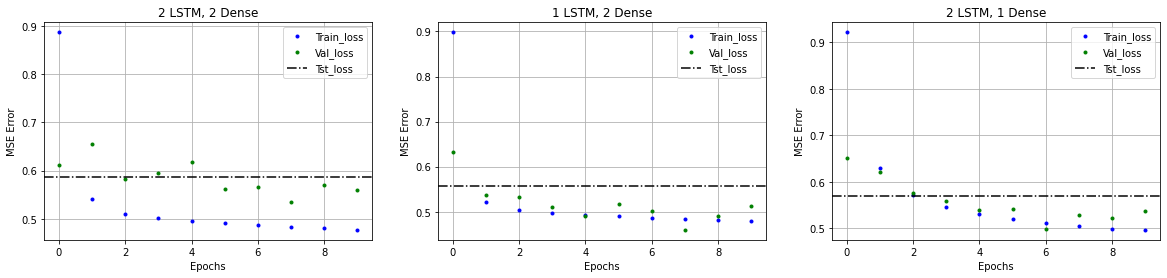

In [ ]:
plt.rcParams["figure.figsize"]=[20,4]

# 2 Capas LSTM y 2 Capas Densas
plt.subplot(1,3,1)
plt.title("2 LSTM, 2 Dense")
plt.plot(history1.history["loss"],"b.",label="Train_loss")
plt.plot(history1.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss1,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()

# 1 Capas LSTM y 2 Capas Densas
plt.subplot(1,3,2)
plt.title("1 LSTM, 2 Dense")
plt.plot(history2.history["loss"],"b.",label="Train_loss")
plt.plot(history2.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss2,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()

# 2 Capas LSTM y 1 Capas Densas
plt.subplot(1,3,3)
plt.title("2 LSTM, 1 Dense")
plt.plot(history3.history["loss"],"b.",label="Train_loss")
plt.plot(history3.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss3,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()


plt.show()

In [ ]:
# Univariado

input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 2° lstm
dens=layers.Dense(32, activation='relu')(rnn) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=input_lstm, outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history1 = model.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=10, batch_size=16,verbose=False)
y_pred=model(x_tst[:,:,0:1])
tst_loss1=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm) # 1° lstm
dens=layers.Dense(56, activation='relu')(rnn) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=input_lstm, outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history2 = model.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=10, batch_size=16,verbose=False)
y_pred=model(x_tst[:,:,0:1])
tst_loss2=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=32,return_sequences=False)(rnn) # 2° lstm
dens=layers.Dense(len_out, activation='sigmoid')(rnn) # 2° densa
model=models.Model(inputs=input_lstm, outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history3 = model.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=10, batch_size=16,verbose=False)
y_pred=model(x_tst[:,:,0:1])
tst_loss3=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 56)            12992     
_________________________________________________________________
lstm_8 (LSTM)                (None, 56)                25312     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1824      
_________________________________________________________________
dense_8 (Dense)              (None, 24)                792       
Total params: 40,920
Trainable params: 40,920
Non-trainable params: 0
_________________________________________________________________
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Sh

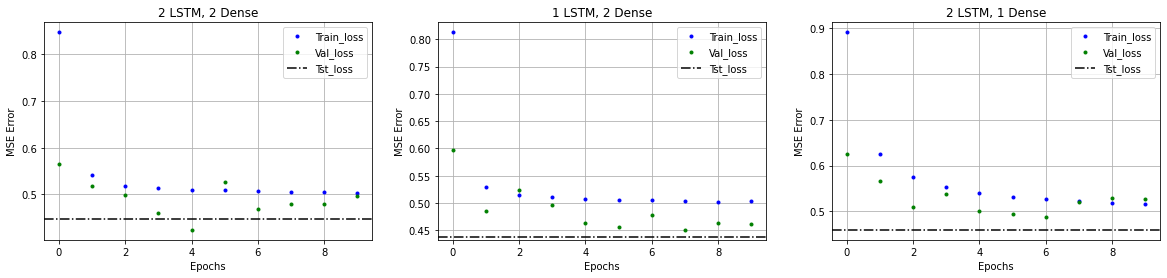

In [ ]:
plt.rcParams["figure.figsize"]=[20,4]

# 2 Capas LSTM y 2 Capas Densas
plt.subplot(1,3,1)
plt.title("2 LSTM, 2 Dense")
plt.plot(history1.history["loss"],"b.",label="Train_loss")
plt.plot(history1.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss1,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()

# 1 Capas LSTM y 2 Capas Densas
plt.subplot(1,3,2)
plt.title("1 LSTM, 2 Dense")
plt.plot(history2.history["loss"],"b.",label="Train_loss")
plt.plot(history2.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss2,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()

# 2 Capas LSTM y 1 Capas Densas
plt.subplot(1,3,3)
plt.title("2 LSTM, 1 Dense")
plt.plot(history3.history["loss"],"b.",label="Train_loss")
plt.plot(history3.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss3,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()


plt.show()

**Comparación**

Stacked LSTM funciona mejor para el modelo univariado que para el multivariado, ya que disminuye el error y no se puede apreciar por el comportamiento de la curva si es que esta sobreajustando o no, mientras que en el multivariado empeora. 

Cuando se tienen 2 capas densas o 2 capas LSTM el modelo univariado también tiene un mejor comportamiento que en el caso del multivariado, aunque en el caso multivariado no se arruina tanto el desempeño a diferencia del stacked LSTM.


**Comentarios**

En el caso multivariado aumentaron los errores compara a cuando se tenía solo una capa LSTM y Densa, por lo que una arquitectura más compleja no necesariamente mejora el desempeño, como se puede observar en este caso. Esto se puede deber a que considerar múltiples variables es complejo en sí, por lo tanto aumentar la coplejidad de la arquitectura dificulta que las predicciones sean correctas.

En el caso del modelo univariado, cuando se tienen 2 capas LSTM y Densas, se ve que el error disminuye y no se aprecia sobreajusto. Esto se debe a que la red LSTM está cumpliendo su objetivo, es decir, esta decidiendo correctamente que información recordar y olvidar. Por lo tanto, se evita el sobreajuste.

**Respuesta**

¿Por qué cuando una capa LSTM precede otra capa LSTM es necesario utilizar return_sequences=True? ¿Es necesario/recomendado utilizar return_sequences=False cuando una capa LSTM precede a una capa Densa?

Es necesario utilizar return-sequences=True, para que la segunda capa LSTM tenga una secuencia de entradas tridimensional, esto debido a que la celda de memoria de LSTM requiere una entrada 3D, entonces return-sequences=True genera una salida 3D. Por esta misma razón, es necesario utilizar return_sequences=False cuando la capa LSTM precede a la capa Densa, ya que la capa Densa recibe entradas 2D.

##### II) Añadiremos entradas a la capa Densa que indiquen la hora del día de forma bi-dimensional, semejante a un reloj, y una variable dummy que indica si es de día o noche. Ejecute el siguiente código para generar las entradas adicionales, y **añada la entrada** a la arquitectura entregada. Esta forma de ingresar variables adicionales a la capa densa se asemeja a la arquitectura skip-connections vista en la Tarea 1. **La hora que se entrega para indicar si es de día o noche es intencionalmente erronea**. Utilizando los datos de radiación del conjunto de entrenamiento **deberá definir las horas de día y noche de manera justificada**. 

**Comente** sobre los resultados obtenidos.

**Pregunta:** ¿Por qué puede resultar beneficioso representar la hora del día de manera bidimensional en lugar de unidimensional? 

In [ ]:
daytimehrs=[6,18]

In [ ]:
from math import *
hour_1_tr=np.asarray(np.sin(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
hour_2_tr=np.asarray(np.cos(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
dummy_tr=(1*(pd.to_datetime(t_tr).hour<daytimehrs[1])*(pd.to_datetime(t_tr).hour>daytimehrs[0])).reshape(-1,1)
hour_1_val=np.asarray(np.sin(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
hour_2_val=np.asarray(np.cos(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
dummy_val=(1*(pd.to_datetime(t_val).hour<daytimehrs[1])*(pd.to_datetime(t_val).hour>daytimehrs[0])).reshape(-1,1)
hour_1_tst=np.asarray(np.sin(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
hour_2_tst=np.asarray(np.cos(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
dummy_tst=(1*(pd.to_datetime(t_tst).hour<daytimehrs[1])*(pd.to_datetime(t_tst).hour>daytimehrs[0])).reshape(-1,1)

ext_tr=np.concatenate((hour_1_tr,hour_2_tr,dummy_tr),axis=1)
ext_val=np.concatenate((hour_1_val,hour_2_val,dummy_val),axis=1)
ext_tst=np.concatenate((hour_1_tst,hour_2_tst,dummy_tst),axis=1)

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
lstm_51 (LSTM)                  (None, 24, 56)       14112       input_50[0][0]                   
__________________________________________________________________________________________________
lstm_52 (LSTM)                  (None, 56)           25312       lstm_51[0][0]                    
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 3)]          0                                            
___________________________________________________________________________________________

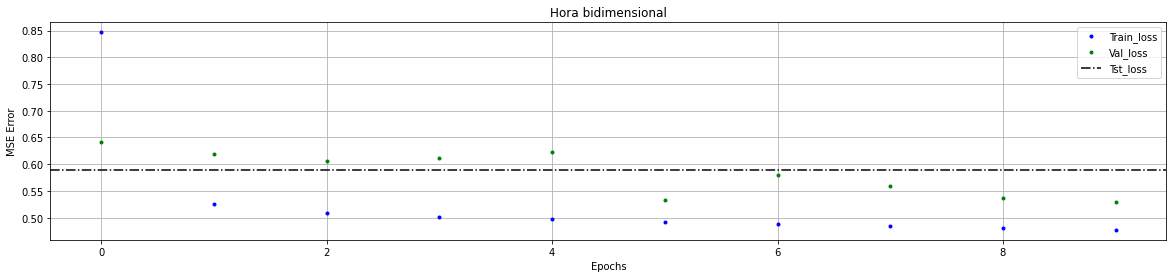

In [ ]:
from keras.layers import concatenate

input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 2° lstm
input_clock= input_layer.Input(shape=(3))
input_dense=concatenate([rnn, input_clock])
dens=layers.Dense(32, activation='relu')(input_dense) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=[input_lstm,input_clock], outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit([x_tr,ext_tr],y_tr, validation_data=([x_val,ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred=model([x_tst,ext_tst])
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

# Gráfico
plt.rcParams["figure.figsize"]=[20,4]
plt.title("Modelo Multivariado - Hora bidimensional")
plt.plot(history.history["loss"],"b.",label="Train_loss")
plt.plot(history.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()
plt.show()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
lstm_53 (LSTM)                  (None, 24, 56)       12992       input_52[0][0]                   
__________________________________________________________________________________________________
lstm_54 (LSTM)                  (None, 56)           25312       lstm_53[0][0]                    
__________________________________________________________________________________________________
input_53 (InputLayer)           [(None, 3)]          0                                            
___________________________________________________________________________________________

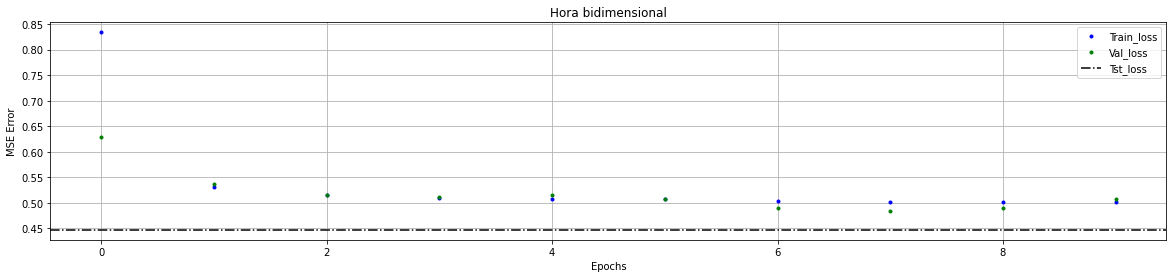

In [ ]:
input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 2° lstm
input_clock= input_layer.Input(shape=(3))
input_dense=concatenate([rnn, input_clock])
dens=layers.Dense(32, activation='relu')(input_dense) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=[input_lstm,input_clock], outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit([x_tr[:,:,0:1],ext_tr],y_tr, validation_data=([x_val[:,:,0:1],ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred=model([x_tst[:,:,0:1],ext_tst])
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

plt.rcParams["figure.figsize"]=[20,4]
# Hora Bidimensional
plt.title("Modelo Univariado - Hora bidimensional")
plt.plot(history.history["loss"],"b.",label="Train_loss")
plt.plot(history.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()
plt.show()

**Comentarios**

Las horas que se identificaron como día fue desde las 6:00 hasta las 18:00, esto debido a que en el grafico (1.V) la curva de radiación empieza a aumentar a partir de las 6:00 y disminuye a 0 a las 18:00, esto indica que durante esas horas hay radiación solar, por lo tanto, es de día.

Además, en los gráficos se ve que el error disminuye levemente en ambos casos, pudiendo concluir que representar la hora del día de manera bidimensional resulta beneficiosa para la predicción.

**Respuesta**

¿Por qué puede resultar beneficioso representar la hora del día de manera bidimensional en lugar de unidimensional?

Esto puede resultar beneficioso porque la radiación se comporta como un ciclo, entonces si se utiliza una representación unidimensional la diferencia entre el valor de las 24 horas y las 0 tendría un salto muy grande, por lo tanto, al hacer esta transformación con senos y cosenos (bidimensional), existe continuidad en los intervalos de tiempo.

##### III) Entrene la misma arquitectura que en la pregunta anterior utilizando unidades GRU en lugar de LSTM. **Explique la diferencia entre GRU y LSTM**. **Compare** los resultados con los obtenidos en el punto anterior.

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
gru_4 (GRU)                     (None, 24, 56)       10584       input_58[0][0]                   
__________________________________________________________________________________________________
gru_5 (GRU)                     (None, 56)           18984       gru_4[0][0]                      
__________________________________________________________________________________________________
input_59 (InputLayer)           [(None, 3)]          0                                            
___________________________________________________________________________________________

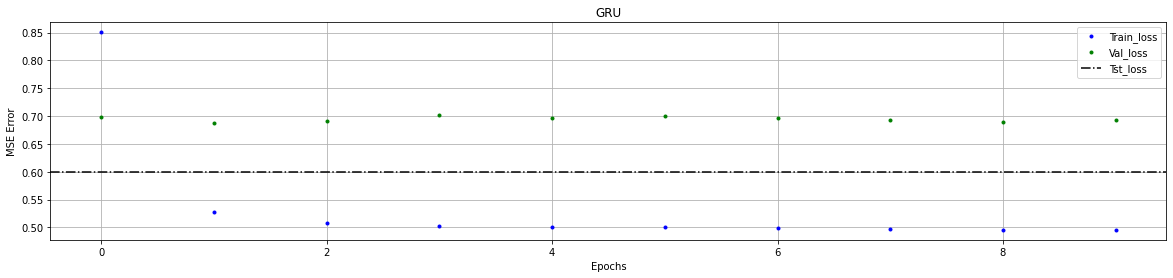

In [ ]:
input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.GRU(units=56,return_sequences=True)(input_lstm) # 1° capa gru
rnn=layers.GRU(units=56,return_sequences=False)(rnn) # 2° capa gru
input_clock= input_layer.Input(shape=(3))
input_dense=concatenate([rnn, input_clock])
dens=layers.Dense(32, activation='relu')(input_dense) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=[input_lstm,input_clock], outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit([x_tr,ext_tr],y_tr, validation_data=([x_val,ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred=model([x_tst,ext_tst])
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

# Gráfico
plt.rcParams["figure.figsize"]=[20,4]
plt.title("GRU")
plt.plot(history.history["loss"],"b.",label="Train_loss")
plt.plot(history.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()
plt.show()

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
gru_6 (GRU)                     (None, 24, 56)       9744        input_60[0][0]                   
__________________________________________________________________________________________________
gru_7 (GRU)                     (None, 56)           18984       gru_6[0][0]                      
__________________________________________________________________________________________________
input_61 (InputLayer)           [(None, 3)]          0                                            
___________________________________________________________________________________________

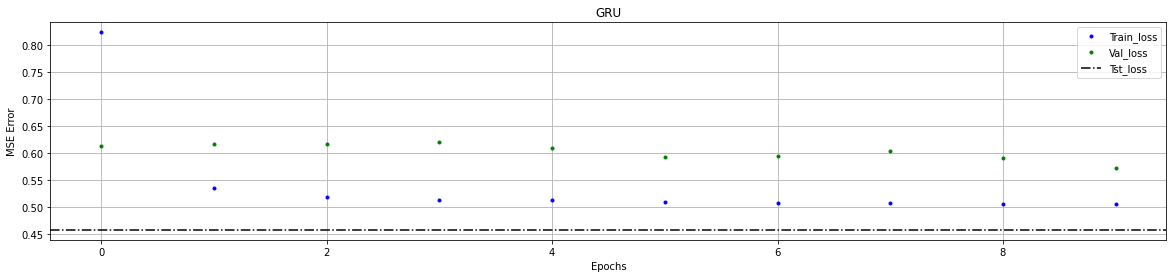

In [ ]:
input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.GRU(units=56,return_sequences=True)(input_lstm) # 1° capa gru
rnn=layers.GRU(units=56,return_sequences=False)(rnn) # 2° capa gru
input_clock= input_layer.Input(shape=(3))
input_dense=concatenate([rnn, input_clock])
dens=layers.Dense(32, activation='relu')(input_dense) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=[input_lstm,input_clock], outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit([x_tr[:,:,0:1],ext_tr],y_tr, validation_data=([x_val[:,:,0:1],ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred=model([x_tst[:,:,0:1],ext_tst])
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

# Gráfico
plt.rcParams["figure.figsize"]=[20,4]
plt.title("GRU")
plt.plot(history.history["loss"],"b.",label="Train_loss")
plt.plot(history.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss,color="k",linestyle="-.",label="Tst_loss")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()
plt.show()

**Diferencias**

La diferencia principal entre GRU y LSTM es que GRU no tiene que usar una unidad de memoria para controlar el flujo de la información como en LSTM, esto busca hacer uso de todos los estados de control de forma directa.

Además, GRU tiene solo 2 compuertas, estas son reset gate y update gate:

* Reset Gate: Determina como combinar la nueva entrada con las entradas previas.
* Update Gate: Define cuanta información anterior mantener. 

Por otro lado, LSTM tiene 3 compuertas como se mencionó anteriormente.

**Comparación**

Para este caso LSTM tiene mejor desempeño que GRU, aunque el error es levemente menor en LSTM, en ninguno de los casos se logra ver sobreajuste, puede que si se aumenta el número de epochs se pueda ver mejor este comportamiento pero puede tardar demasiado tiempo.

Este comportamiento se puede deber a que LSTM ocupa más parámetros (42.000), mientras que GRU utiliza 32.000 parámetros, por lo tanto, es más precisa que GRU y tiene menor error. Por esta misma razón, GRU tiende a demorarse menos y ocupar menos recursos.

##### IV) Con la red con mejor rendimiento, respecto al error de validación, en este punto 1.c) ejecute el siguiente código y saque conclusiones del violin plot.

**Pregunta:** ¿Qué hace un violin plot?

Model: "model_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
lstm_110 (LSTM)              (None, 24, 56)            14112     
_________________________________________________________________
lstm_111 (LSTM)              (None, 56)                25312     
_________________________________________________________________
dense_106 (Dense)            (None, 32)                1824      
_________________________________________________________________
dense_107 (Dense)            (None, 24)                792       
Total params: 42,040
Trainable params: 42,040
Non-trainable params: 0
_________________________________________________________________


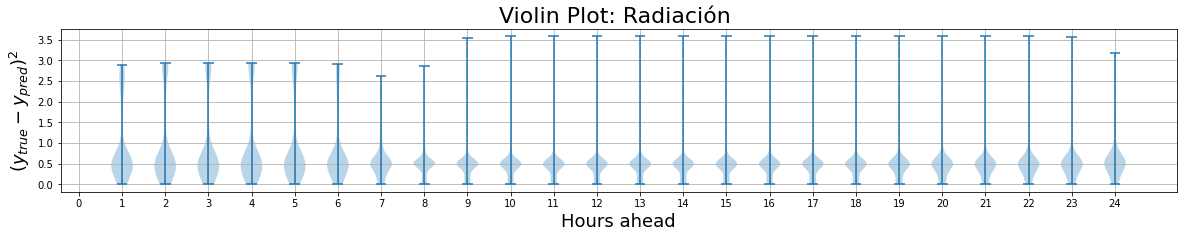

In [ ]:
# Red 
input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 2° lstm
dens=layers.Dense(32, activation='relu')(rnn) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=input_lstm, outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=False)

y_pred=model(x_tst)
tst_loss=((y_tst- y_pred)**2).numpy()
plt.rcParams["figure.figsize"]=[20,3]
plt.title("Violin Plot: Radiación ",size=22)
plt.violinplot(tst_loss)
plt.xlabel("Hours ahead",size=18)
plt.ylabel("$(y_{true}-y_{pred})^2$",size=18)
plt.xticks(np.arange(25))
plt.grid()
plt.show()

La red de 1.c que se utilizó fue la stacked LSTM multivariada (1.c.i), ya que toma más información que la univariada y se tiene información de las 24 horas (unidimensional).

**Respuesta**

¿Qué hace un violin plot?

Violin plot muesta la probabilidad de densidad y los cuartiles de la distribución. Por lo tanto, en los gráficos se puede apreciar error que se alcanza en determinadas horas, además las partes más delgadas del violin son datos atípicos (outlier).


## 1.d) Parameters & hyperparameters tunning. 

##### I) Como se habrá percatado, existe una **inmensa** cantidad de hiperparámetros que uno puede ajustar en las arquitecturas de redes neuronales (learning rate, profundidad de red, n° de neuronas en cada capa, optimizador, cantidad de epochs), también se puede considerar como hiperparámetro si es que incluir o no métodos tales como batch normalization, regularización L1/L2 o dropout en la red neuronal, a la vez habrá qué decidir dónde situar estos métodos, y cómo ajustar sus propios hiperparámetros. Aún más, también es posible experimentar con la manipulación del dataset, p.ej decidir si usar una entrada univariada, multivariada, o un punto intermedio (y si es un punto intermedio qué variables ocupar), también es posible variar el largo de las series de tiempo de entrada.

Prepare un código para hacer **Random Search**, dado que los tiempos de entrenamiento serán desproporcionados, **NO ENTRENE** las redes neuronales, pero evalúe en el conjunto de validación como si las hubiese entrenado para escoger los ""mejores"" parámetros & hiperparámetros de la red neuronal. Mantenga el objetivo de predecir la radiación para las siguientes 24 horas. **Imprima** (print) los valores de los parámetros & hiperparámetros de la red que se esté evaluando, indicando a qué corresponde, y recolecte el error de validación. Realice un Random Search de largo 100, apóyese en el código entregado, **expándalo** desde la búsqueda de 3 hiperparámetros/parámetros hasta una búsqueda de al menos **12** hiperparámetros/parámetros, puede escoger de los ejemplos dados en el primer párrafo de este ítem, o bien escoger por su propia cuenta. El código debe ser funcional, es decir, las _arquitecturas/manipulaciones del dataset_ indicadas por los hiperparámetros/parámetros deben ser efectivamente aplicadas en la construcción de la red neuronal y/o manipulación de datos. Note que en el código dado, un hiperparámetro a ajustar es recurrent dropout. **Indique** cuál fue la mejor arquitectura encontrada según el error de validación.

**Preguntas:** 

i) ¿Qué alternativas al Random Search existen? Nombre al menos una. 

ii) ¿Qué hace el método recurrent dropout?

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
optimizers = [SGD, Adam, RMSprop, Adagrad, Adadelta]
kernel_initializers = ['he_uniform','glorot_normal','glorot_uniform']
activations = ['sigmoid','tanh']
inputs = ['univariada', 'multivariada'] #univariado o multivariado
val_h=[]

for random_search in range(100):
  prof_rnn=np.random.randint(1,4)
  neu_rnn=[np.random.randint(20,40) for t in range(prof_rnn)]
  optimizer = optimizers[np.random.randint(0,4)]
  activation = activations[np.random.randint(0,1)]
  input = inputs[np.random.randint(0,1)]
  kernel_initializer = kernel_initializers[np.random.randint(0,3)]
  rec_drop=np.random.uniform(0,0.7)
  learn_rate = np.random.uniform(1e-6, 1e-1)
  learn_decay = np.random.uniform(1e-6, 1e-1)

  if( input == 'univariada'):
    input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
    for i,neu in enumerate(neu_rnn):
      if i==0: rnn=layers.LSTM(units=neu_rnn[0],return_sequences=True,recurrent_dropout=rec_drop, kernel_initializer=kernel_initializer)(input_lstm)
      else: rnn=layers.LSTM(units=56,return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop, kernel_initializer=kernel_initializer)(rnn)
    dens=layers.Dense(len_out, activation=activation)(rnn)
    model=models.Model(inputs=input_lstm, outputs=dens)

    model.compile(loss='mse', optimizer=optimizer(decay=learn_decay, learning_rate=learn_rate))
    y_pred=model(x_val[:,:,0:1])
  
  else:
    input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
    for i,neu in enumerate(neu_rnn):
      if i==0: rnn=layers.LSTM(units=neu_rnn[0],return_sequences=True,recurrent_dropout=rec_drop, kernel_initializer=kernel_initializer)(input_lstm)
      else: rnn=layers.LSTM(units=56,return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop, kernel_initializer=kernel_initializer)(rnn)
    dens=layers.Dense(len_out, activation=activation)(rnn)
    model=models.Model(inputs=input_lstm, outputs=dens)

    model.compile(loss='mse', optimizer=optimizer(decay=learn_decay, learning_rate=learn_rate))
    y_pred=model(x_val)
  val_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_val[1], y_pred)).numpy()
  val_h.append(val_loss)
  print(random_search+1,"° --->  Profundidad rnn: ",prof_rnn, " | N° neuronas: ", neu_rnn, " | Recurrent dropout: ", rec_drop)
  print("   ° --->  Optimizador: ",optimizer, " | F. Activación: ", activation, " | Entrada: ", input)
  print("   ° --->  Inic. Kernel: ",kernel_initializer, " | Learning rate: ", learn_rate, " | Learn Decay: ", learn_decay)
  print("Validation error: ",val_loss)
  print("-"*120)

print("La mejor arquitectura se encuentra en ", np.argmin(np.array(val_h))+1)

1 ° --->  Profundidad rnn:  3  | N° neuronas:  [31, 38, 39]  | Recurrent dropout:  0.34146738157195017
   ° --->  Optimizador:  <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>  | F. Activación:  sigmoid  | Entrada:  univariada
   ° --->  Inic. Kernel:  glorot_normal  | Learning rate:  0.04757349618146372  | Learn Decay:  0.017454275261406096
Validation error:  1.1341661
------------------------------------------------------------------------------------------------------------------------
2 ° --->  Profundidad rnn:  1  | N° neuronas:  [32]  | Recurrent dropout:  0.2620899519804439
   ° --->  Optimizador:  <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>  | F. Activación:  sigmoid  | Entrada:  univariada
   ° --->  Inic. Kernel:  glorot_normal  | Learning rate:  0.09866784007013264  | Learn Decay:  0.042895918133470594
Validation error:  1.1293806
-----------------------------------------------------------------------------------------------------------

**Respuestas**

i) ¿Qué alternativas al Random Search existen? Nombre al menos una.

Las alternarnativas que existen son Babysitting (o prueba y error), Grid Search y Bayesian Optimization.

* Babysitting (o prueba y error): Consiste en ir a mano ajustando los hiperparámetros a través de experimentos que permitan evaluar como mejora el desempeño al setear determinados valores. Esto se realiza hasta que la persona no tenga más tiempo para seguir probando.
 
* Grid Search: A diferencia de Random Search, Grid Search evalua y setea los hiperparámetros de manera ordenada y no aleatoria.

ii) ¿Qué hace el método recurrent dropout?

El método recurrent dropout descarta las conexiones entre unidades recurrentes, a diferencia del dropout clásico ya que este se realiza en la capa de entrada y/o en la capa de salida.

##### II) Implemente sobre el código de Random Search la funcionalidad de realizar Cross-Validation con 5 Folds para cada red neuronal creada en el proceso de Random Search. Dado que se está trabajando con series de tiempo ocupe la función TimeSeriesSplit. Nuevamente **NO ENTRENE** las redes neuronales. El conjunto de entrenamiento y validación deben ser uno inicialmente para luego ser divididos en cada Fold, el conjunto de test se debiese mantener hasta el final. Calcule el error en el conjunto de validación de cada Fold y use el promedio de los 5 Folds para evaluar el rendimiento de cada red neuronal, encuentre los ""mejores"" parámetros/hiperparámetros basado en estos promedios.

**Preguntas:**

i) Visite la página https://scikit-learn.org/stable/modules/cross_validation.html . **Nombre y explique** el método TimeSeriesSplit y al menos otros 3 métodos de cross-validation. ¿Por qué time series split es adecuado para nuestro caso?

ii) ¿Cuáles son los fundamentos de Cross Validation en general (como herramienta de selección de hiperparámetros)?

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()

data_tr_fold = [0,0,0,0,0]
data_val_fold = [0,0,0,0,0]

fold_tr = np.zeros((5))
fold_val = np.zeros((5))

data_tr_val, time_tr_val = data_hr[:int(data_hr.shape[0]*0.85)],time_hr[:int(data_hr.shape[0]*0.85)] # DIVIDE IN EACH FOLD

data_tst, time_tst = data_hr[int(data_hr.shape[0]*0.85):],time_hr[int(data_hr.shape[0]*0.85):] # KEEP IT UNTIL THE END

# se debiese estandarizar en cada Fold ajustando el scaler con la data de entrenamiento que se genere
scaler_x = StandardScaler()


#Random Search + Cross-Validation con 5 Folds
val = np.zeros((5))
for train_index, val_index in tscv.split(data_tr_val):
  scaler_x.fit(data_tr_val[train_index])
  optimizers = [SGD, Adam, RMSprop, Adagrad, Adadelta]
  kernel_initializers = ['he_uniform','glorot_normal','glorot_uniform']
  activations = ['sigmoid','tanh']
  inputs = ['univariada', 'multivariada'] #univariado o multivariado
  val_h=[]
  config = []
  for random_search in range(100):
    prof_rnn=np.random.randint(1,4)
    neu_rnn=[np.random.randint(20,40) for t in range(prof_rnn)]
    optimizer = optimizers[np.random.randint(0,4)]
    activation = activations[np.random.randint(0,1)]
    input = inputs[np.random.randint(0,1)]
    kernel_initializer = kernel_initializers[np.random.randint(0,3)]
    rec_drop=np.random.uniform(0,0.7)
    learn_rate = np.random.uniform(1e-6, 1e-1)
    learn_decay = np.random.uniform(1e-6, 1e-1)

    if( input == 'univariada'):
      input_lstm= input_layer.Input(shape=(scaler_x.transform(data_tr_val[train_index]).shape[1],1))
      for i,neu in enumerate(neu_rnn):
        if i==0: rnn=layers.LSTM(units=neu_rnn[0],return_sequences=True,recurrent_dropout=rec_drop, kernel_initializer=kernel_initializer)(input_lstm)
        else: rnn=layers.LSTM(units=56,return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop, kernel_initializer=kernel_initializer)(rnn)
      dens=layers.Dense(len_out, activation=activation)(rnn)
      model=models.Model(inputs=input_lstm, outputs=dens)
      model.compile(loss='mse', optimizer=optimizer(decay=learn_decay, learning_rate=learn_rate))
      y_pred=model(scaler_x.transform(data_tr_val[val_index])[:,:])
    
    else:
      input_lstm= input_layer.Input(shape=(scaler_x.transform(data_tr_val[train_index]).shape[1:]))
      for i,neu in enumerate(neu_rnn):
        if i==0: rnn=layers.LSTM(units=neu_rnn[0],return_sequences=True,recurrent_dropout=rec_drop, kernel_initializer=kernel_initializer)(input_lstm)
        else: rnn=layers.LSTM(units=56,return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop, kernel_initializer=kernel_initializer)(rnn)
      dens=layers.Dense(len_out, activation=activation)(rnn)
      model=models.Model(inputs=input_lstm, outputs=dens)

      model.compile(loss='mse', optimizer=optimizer(decay=learn_decay, learning_rate=learn_rate))
      y_pred=model(scaler_x.transform(data_tr_val[val_index]))
    val[i]=tf.math.reduce_mean(tf.keras.losses.MSE(y_val[1], y_pred)).numpy()

    val_loss = val.mean()
    val_h.append(val_loss)
    config.append([prof_rnn,neu_rnn,rec_drop,optimizer,activation,input,kernel_initializer,learn_rate,learn_decay])
  index = np.argmin(np.array(val_h))
  print(index+1,"° --->  Profundidad rnn: ",config[index][0], " | N° neuronas: ", config[index][1], " | Recurrent dropout: ", config[index][2])
  print("  ° --->  Optimizador: ",config[index][3], " | F. Activación: ", config[index][4], " | Entrada: ", config[index][5])
  print("  ° --->  Inic. Kernel: ",config[index][6], " | Learning rate: ", config[index][7], " | Learn Decay: ", config[index][8])
  print("Validation error: ",val_h[index])
  print("-"*120)

1 ° --->  Profundidad rnn:  2  | N° neuronas:  [36, 28]  | Recurrent dropout:  0.6685196925058744
  ° --->  Optimizador:  <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>  | F. Activación:  sigmoid  | Entrada:  univariada
  ° --->  Inic. Kernel:  glorot_normal  | Learning rate:  0.02228843183578243  | Learn Decay:  0.06625041963915146
Validation error:  0.22697839736938477
------------------------------------------------------------------------------------------------------------------------
99 ° --->  Profundidad rnn:  3  | N° neuronas:  [23, 29, 25]  | Recurrent dropout:  0.44329061858004853
  ° --->  Optimizador:  <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>  | F. Activación:  sigmoid  | Entrada:  univariada
  ° --->  Inic. Kernel:  he_uniform  | Learning rate:  0.06060491925924003  | Learn Decay:  0.09388175545430255
Validation error:  0.6684823274612427
--------------------------------------------------------------------------------------------

**Respuestas**

i) Visite la página https://scikit-learn.org/stable/modules/cross_validation.html . Nombre y explique el método TimeSeriesSplit y al menos otros 3 métodos de cross-validation. ¿Por qué time series split es adecuado para nuestro caso?

El método TimeSeriesSplit entrega los primeros k-fold como conjunto de entrenamiento, y los siguientes como conjunto de test, en este caso ese será el conjunto de validación. Se agregan datos del conjunto de validación en el conjunto de entrenamiento posterior, para no desechar los datos del conjunto de validación.

* K-fold:
Divide todas las muestras en grupos (llamados fold). La red aprende usando estos folds para predecir y los que no son usados en entrenamiento, se utilizan para realizar las pruebas.

* Stratified k-fold:
Es una variación de k-fold, que soluciona el problema de clasificación que ocurre cuando las clases tienen una proporción, este método permite dividir la data manteniendo esa proporción.

* Leave One Out (LOO)
En cada set creado se toman todas las muestras menos 1, el cual pertenece al conjunto de entrenamiento. De esta forma, se evita desperdiciar muchos datos ya que solo se quita 1 del conjunto de entrenamiento.

Es adecuado para este problema porque es el único método de Cross Validation que considera las series de tiempo, es decir, el tiempo es secuencial y los intervalos son fijos. 


ii) ¿Cuáles son los fundamentos de Cross Validation en general (como herramienta de selección de hiperparámetros)?

Los fundamentos de Cross Validation, es tomar un conjunto de validación más prometedor. Para este caso se tomaron todos los datos secuenciales entre el conjunto de entrenamiento y prueba, sin embargo, utilizando cross validation, se busca tomar datos en todo el arreglo, y que para un fold, una parte sea de entrenamiento y otra de validación, estos datos no necesariamente se encuentran al inicio o al final, teniendo así más variedad que en un comienzo. 

De esta forma, se busca un mejor conjunto de validación para setear los hiperparámetros y reducir el error de generalización en ese conjunto de datos. Así, se busca tener un mejor modelo que pueda obtener menor error de generalización en las pruebas utilizando los "mejores" hiperparámetros definidos por el conjunto de validación.